### Linear regression example
A linear regression example, representing a relatively minimal example for how softcvi can be used.

### Imports

In [1]:
from typing import ClassVar

import jax.numpy as jnp
import jax.random as jr
import matplotlib.pyplot as plt
from flowjax.distributions import Normal
from flowjax.experimental.numpyro import sample
from flowjax.train import fit_to_key_based_loss
from jaxtyping import Array, PRNGKeyArray

from pyrox.losses import EvidenceLowerBoundLoss
from pyrox.program import AbstractProgram, SetKwargs


/home/dw16200/miniconda3/envs/pyrox_env/lib/python3.13/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define the model

In [2]:

class RegressionModel(AbstractProgram):
    sigma: float | int
    n_covariates: ClassVar[int] = 100
    n_obs: ClassVar[int] = 200

    def __init__(self):
        self.sigma = 1

    def __call__(
        self,
        *,
        obs: Array | None = None,
        x: Array,
    ):
        beta = sample("beta", Normal(jnp.zeros(self.n_covariates)))
        bias = sample("bias", Normal())
        mu = x @ beta + bias
        sample("y", Normal(mu, self.sigma), obs=obs)


class RegressionGuide(AbstractProgram):
    beta: Normal
    bias: Normal

    def __init__(self):
        self.beta = Normal(jnp.zeros(RegressionModel.n_covariates))
        self.bias = Normal()

    def __call__(self):
        sample("beta", self.beta)
        sample("bias", self.bias)

model = RegressionModel()
guide = RegressionGuide()

### Generate toy data

In [3]:
key, subkey = jr.split(jrs.key(0))
x = jr.normal(key, (model.n_obs, model.n_covariates))  # Generate toy data
latents = model.sample(subkey, x=x)
obs = latents.pop("y")

### Fit posterior

In [4]:
loss = EvidenceLowerBoundLoss(n_particles=1)
key, subkey=jr.split(key)

# Set the kwarg values before passing to loss
model = SetKwargs(model, obs=obs, x=x)
(model, guide), losses = fit_to_key_based_loss(
    key=subkey,
    tree=(model, guide),
    loss_fn=loss,
    steps=5000,
    learning_rate=1e-2,
)
model = model.program # unwrap SetKwargs

100%|██████████| 5000/5000 [00:20<00:00, 248.76it/s, loss=564]   


Text(0, 0.5, '$\\beta$ posterior mean')

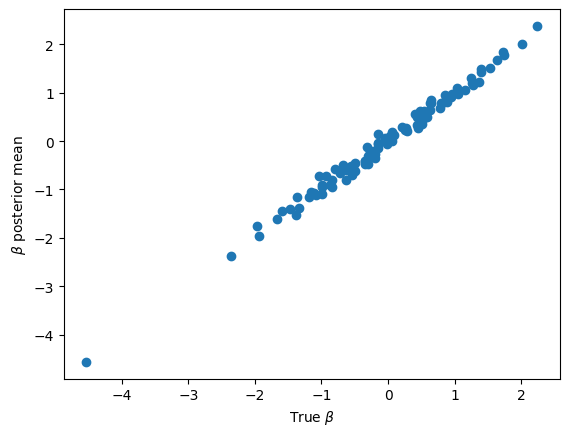

In [5]:
# Plot true coefficients against posterior means
plt.scatter(latents["beta"], guide.beta.loc)
plt.xlabel(r"True $\beta$")
plt.ylabel(r"$\beta$ posterior mean")
